# ECDF curve study

In the last analysis , we trained NN on imbalanced data and got an ECDF curve where BH curve was broader than NS curve.

### Dataset description 
| BH sources | NS Sources |
|------------|------------|
| 152        |    288     |


![curve](pred_result/ns_bh_post_prob_ecdf.jpg?arg3)

## Methodology 

* Make the two dataset equal
* then do the training and get ECDF 
* See if BH is still broader

In [31]:
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt 


In [32]:
def split_data(x,y,s,id,frac):
    split_no = int(len(y)*frac )
    x_train = x[:split_no]
    x_test = x[split_no:]
    y_train = y[:split_no]
    y_test = y[split_no:]
    s_train = s[:split_no]
    s_test = s[split_no:]
    id_train = id[:split_no]
    id_test = id[split_no:]
    return (x_train , y_train , s_train , id_train ) , (x_test , y_test , s_test , id_test)

def class_to_int(label , cl):
    temp = []
    for i in range(len(label)):
        #print(label[i])
        for j in range(len(cl)):
            if(label[i]==cl[j]):
                temp.append(j) 
    return temp


In [118]:
def filter_data(data):  
    max_flux = 12
    min_flux = 26
    data = data.copy()
    data = data[data['flux_aper']>max_flux]
    data = data[data['flux_aper']<min_flux]
    data = data[data['flux_aper_lolim']<min_flux]
    data = data[data['flux_aper_hilim']>(max_flux-2)]
    data = data[data['significance']>2]
    data = data.sample(frac=1)
    return data 

def extract_data(data):
    #display(data.describe())
    data_class = data[['class']]
    data_id = data['src_id']
    data_name = data['src_name']
    data_sig = data[['flux_significance']]
    data_val = data.drop(columns=['flux_significance' ,  'index' , 'livetime' , 'gti_obs' , 'significance' , 'likelihood' , 'class' ,'src_id' ,'src_name'])

    #display(data_val)
    #import missingno as msno
    #msno.matrix(data_val)
    #plt.show()

    data_val = data_val.replace(np.nan , 0)

    for d in data_val:
        #
        mean = np.mean(data_val[d])
        var = np.var(data_val[d])
        #data_val[d] = (data_val[d])-mean
        #data_val[d] = (data_val[d])*var
        data_val[d] = data_val[d] / np.amax(data_val[d])
    #msno.matrix(data_val)
    #plt.show()
    display()
    return data , data_val , data_class , data_id , data_sig 

Making the length of two dataset identical , after data filtering

In [120]:
train_bh = pd.read_csv('processed_data/BH_train.csv')
train_bh = train_bh.sample(frac=1)
train_bh = filter_data(train_bh)
display(train_bh.describe().iloc[:2,4:])

train_ns = pd.read_csv('processed_data/NS_train.csv')
train_ns = train_ns.sample(frac=1)
train_ns = filter_data(train_ns)[:len(train_bh)]
display(train_ns.describe().iloc[:2,4:])

train = pd.concat([train_bh , train_ns ] , axis=0)
train =  train.sample(frac=1)

train_data ,  data_val , data_class , data_id , data_sig = extract_data(train)
print('FINAL DATASET TO TRAINING')
data_val.describe().iloc[:,4:]

,var_inter_sigma,var_inter_prob,var_inter_index,var_max,var_min,var_mean,var_sigma,kp_prob,ks_prob,var_prob,...,flux_brems_lolim,flux_brems_hilim,brems_kt_hilim,brems_kt_lolim,brems_nh_hilim,brems_nh_lolim,bb_kt_hilim,bb_kt_lolim,bb_nh_hilim,bb_nh_lolim
count,149.000000,149.000000,149.000000,112.000000,112.00000,112.000000,112.000000,112.000000,112.000000,112.000000,...,24.000000,24.000000,23.000000,24.000000,24.000000,23.00000,24.000000,24.000000,24.000000,14.00
mean,0.000157,0.794317,5.715101,0.007248,0.00371,0.004399,0.000708,0.516661,0.523707,0.451002,...,12.942296,12.829105,4.906348,5.966875,468.447488,404.35275,0.872675,0.712267,357.518962,490.36


,var_inter_sigma,var_inter_prob,var_inter_index,var_max,var_min,var_mean,var_sigma,kp_prob,ks_prob,var_prob,...,flux_brems_lolim,flux_brems_hilim,brems_kt_hilim,brems_kt_lolim,brems_nh_hilim,brems_nh_lolim,bb_kt_hilim,bb_kt_lolim,bb_nh_hilim,bb_nh_lolim
count,137.000000,137.00000,137.000000,101.000000,101.000000,101.000000,101.000000,101.00000,101.00000,101.000000,...,28.000000,28.000000,26.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,18.000000
mean,0.000617,0.85557,6.262895,0.015377,0.010886,0.013151,0.001068,0.48213,0.49547,0.409949,...,12.498064,12.430234,3.482935,2.488743,118.522143,72.960714,3.426396,0.449304,70.786075,34.561278


FINAL DATASET TO TRAINING


,var_min,var_mean,var_sigma,kp_prob,ks_prob,var_prob,var_index,flux_aper_hilim,flux_aper_lolim,flux_aper,...,flux_brems_lolim,flux_brems_hilim,brems_kt_hilim,brems_kt_lolim,brems_nh_hilim,brems_nh_lolim,bb_kt_hilim,bb_kt_lolim,bb_nh_hilim,bb_nh_lolim
count,3.040000e+02,3.040000e+02,3.040000e+02,3.040000e+02,3.040000e+02,3.040000e+02,3.040000e+02,3.040000e+02,3.040000e+02,3.040000e+02,...,3.040000e+02,3.040000e+02,3.040000e+02,3.040000e+02,3.040000e+02,3.040000e+02,3.040000e+02,3.040000e+02,3.040000e+02,3.040000e+02
mean,-3.697700e-18,-4.382459e-18,3.030060e-18,5.184769e-17,-9.294466e-17,-1.332998e-16,2.962725e-17,-4.269976e-15,-1.245075e-15,-1.840998e-15,...,-5.185910e-17,-1.150396e-17,-1.826025e-18,4.222682e-19,-4.382459e-18,-1.620597e-18,1.132706e-17,-1.780374e-18,-9.130124e-19,-1.937869e-17
std,1.189341e-01,1.360201e-01,7.202938e-02,4.572967e-01,4.782417e-01,3.553184e-01,1.226453e-01,4.217627e-01,3.366807e-01,3.891139e-01,...,3.940691e-01,3.946158e-01,8.786420e-02,6.312582e-02,1.444438e-01,1.358915e-01,5.768738e-02,1.042333e-01,1.473398e-01,1.294977e-01
min,-4.188723e-02,-5.073740e-02,-1.291514e-02,-5.403827e-01,-5.570812e-01,-4.426659e-01,-5.592220e-02,-1.061803e+00,-7.621342e-01,-9.319471e-01,...,-1.783771e-01,-1.786831e-01,-1.908899e-02,-8.686405e-03,-2.878384e-02,-2.577389e-02,-4.646591e-03,-3.777100e-02,-2.748255e-02,-2.152165e-02
25%,-4.188723e-02,-5.073740e-02,-1.291514e-02,-5.403827e-01,-5.570812e-01,-4.426659e-01,-5.592220e-02,-2.703468e-01,-1.963558e-01,-2.295114e-01,...,-1.783771e-01,-1.786831e-01,-1.908899e-02,-8.686405e-03,-2.878384e-02,-2.577389e-02,-4.646591e-03,-3.777100e-02,-2.748255e-02,-2.152165e-02
50%,-3.946395e-02,-4.809386e-02,-1.237676e-02,6.231205e-02,-1.411260e-02,1.058614e-01,-5.592220e-02,7.684105e-03,1.730122e-02,-1.895414e-03,...,-1.783771e-01,-1.786831e-01,-1.908899e-02,-8.686405e-03,-2.878384e-02,-2.577389e-02,-4.646591e-03,-3.777100e-02,-2.748255e-02,-2.152165e-02
75%,-2.466412e-02,-3.178603e-02,-9.872660e-03,3.125163e-01,3.398686e-01,2.670279e-01,2.229426e-02,3.794128e-01,1.998705e-01,2.869518e-01,...,-1.783771e-01,-1.786831e-01,-1.908899e-02,-8.686405e-03,-2.878384e-02,-2.577389e-02,-4.646591e-03,-3.777100e-02,-2.748255e-02,-2.152165e-02
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [114]:

x = data_val
y = data_class.to_numpy()
s = data_sig.to_numpy()
s = s
#s = [float(si) for si in s]
(x_train , y_train , s_train , id_train) , (x_test , y_test , s_test , id_test) =  split_data(x, y,s, data_id , 1)
print(x_train.shape , y_train.shape)
print(x_test.shape , y_test.shape)

(304, 92) (304, 1)
(0, 92) (0, 1)


In [115]:

classes = ['BH' ,'NS' ]
y_train_int = class_to_int(y_train, classes)
one_hot_y_train =  to_categorical(y_train_int)

desc_class = pd.DataFrame()
y_class_ser = (np.asarray(y_train).reshape(len(y_train)))
desc_class.insert(0, 'cl', y_class_ser)
ns_n = desc_class.value_counts()['NS']
bh_n= desc_class.value_counts()['BH']
print(ns_n , bh_n)

152 152


In [116]:

def model_gen(shape , input_len):

    inputs =  keras.Input(shape=(input_len,))
    dense =  layers.Dense(32, activation='relu')
    x = dense(inputs)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(16, activation='relu')(x)
    outputs = layers.Dense(2 , activation='softmax')(x)
    model = keras.Model(inputs=inputs , outputs=outputs , name='trial_model')
    model.compile(
        loss = "categorical_crossentropy",
        optimizer = keras.optimizers.Adam(learning_rate=0.0005),
        metrics = ["accuracy"],
    )
    return model
model = model_gen([32,32,16,8] , x_train.shape[1])

history = model.fit(x_train, one_hot_y_train, batch_size=32, epochs=70, validation_split=0.2 , sample_weight=s_train*5)


Epoch 1/70
8/8 [==============================] - 2s 122ms/step - loss: 16.8868 - accuracy: 0.5128 - val_loss: 15.7204 - val_accuracy: 0.5246
Epoch 2/70
8/8 [==============================] - 0s 48ms/step - loss: 13.5631 - accuracy: 0.5925 - val_loss: 15.5615 - val_accuracy: 0.6393
Epoch 3/70
8/8 [==============================] - 0s 41ms/step - loss: 13.0726 - accuracy: 0.6314 - val_loss: 15.3480 - val_accuracy: 0.7049
Epoch 4/70
8/8 [==============================] - 0s 31ms/step - loss: 13.6019 - accuracy: 0.6914 - val_loss: 14.9145 - val_accuracy: 0.6557
Epoch 5/70
8/8 [==============================] - 0s 23ms/step - loss: 13.3467 - accuracy: 0.6631 - val_loss: 14.6142 - val_accuracy: 0.6393
Epoch 6/70
8/8 [==============================] - 0s 38ms/step - loss: 10.4359 - accuracy: 0.7153 - val_loss: 14.2716 - val_accuracy: 0.6721
Epoch 7/70
8/8 [==============================] - 1s 66ms/step - loss: 11.3707 - accuracy: 0.7011 - val_loss: 13.9920 - val_accuracy: 0.7049
Epoch 8/70
8

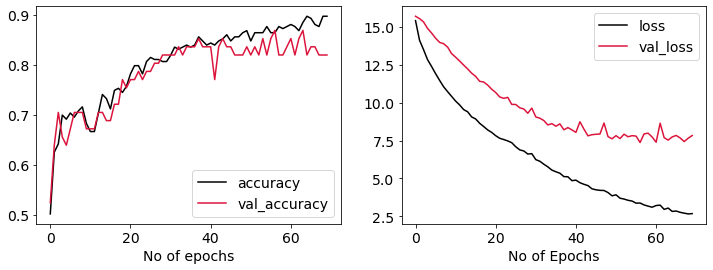

In [117]:
hist = history.history
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(hist['accuracy'] , label = 'accuracy' , color='k')
plt.plot(hist['val_accuracy'] , label = 'val_accuracy' , color='crimson')
plt.xlabel('No of epochs')
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist['loss'] , label = 'loss' , color='k')
plt.plot(hist['val_loss'] , label='val_loss' , color='crimson')
plt.xlabel("No of Epochs")
plt.legend()
#plt.savefig('plots/NS_BH.png')
plt.show()

## Result analysis

In [58]:
import seaborn as sns
%reload_ext autoreload
%autoreload 2
#from my_utils.score import test_func , conf_matrix
from my_utils.print_lines import *

font = {'size'   : 14}
plt.rc('font', **font)

In [59]:
test_data_result = train_data.copy(deep=True)
y_prob = model.predict(x_train)

y_pred = []
for yi in y_prob:
    temp = [int(0)]*len(yi)
    temp[np.argmax(yi)] = int(1)
    y_pred.append(temp)
y_pred =  np.asarray(y_pred)

y_prob_val = [np.amax(yi) for yi in y_prob]
y_prob_class =[classes[np.argmax(yi)] for yi in y_prob]
y_truth = [np.dot(yi , yt) for yi , yt in zip(y_pred , one_hot_y_train)]
y_truth = np.asarray(y_truth)
test_data_result.insert(3 ,'pred_class' , y_prob_class)
test_data_result.insert(4 ,'prob' , y_prob_val)
test_data_result.insert(2 ,'is_ok' , y_truth.astype(int))

test_data_result = test_data_result.sort_values(by='src_id' , axis=0)
test_data_result = test_data_result.drop(columns=['index'])
#display(test_data_result)


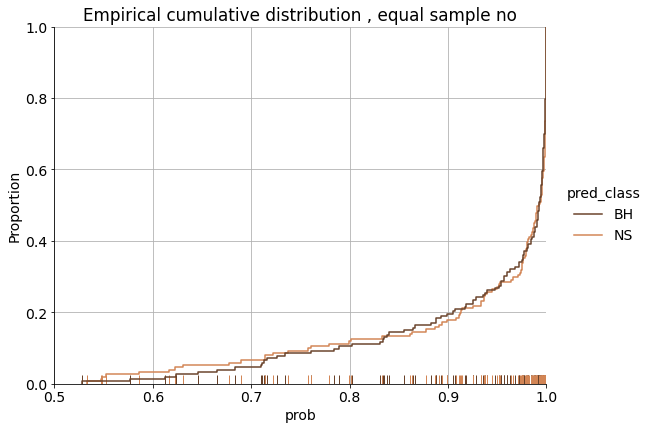

In [61]:
#plt.figure( figisze=(8,6))
data = pd.read_csv('pred_result/temp.csv')
data = data[['prob' ,'pred_class']]
s = sns.displot(
    data = data, x='prob' , 
    hue='pred_class' , kind='ecdf' , 
    rug=True, height=6 , aspect=8/6 , palette='copper')
#s.set_titles("Predicted prob distribution")
plt.xlim(0.5 , 1.0)
plt.title("Empirical cumulative distribution , equal sample no")
#plt.axvline(1.0 , 0,5 , color='black')
plt.grid()
plt.savefig('pred_result/ns_bh_post_prob_ecdf_equal_samples.jpg')
plt.show()
plt.close()


## Result

<img src='pred_result/ns_bh_post_prob_ecdf.jpg?arg6'>
<img src='pred_result/ns_bh_post_prob_ecdf_equal_samples.jpg?arg7'>

## Observation

* NS and BH ecdf curves have become similar 
* NS curve have become slightly broader

## Inference

* Prediction accuracy for NS has gone down
* Broader curve for BH was due to imbalanced dataset
* Need to do some data augmentation in BH dataset to bring it to the same level as of NS dataset

# Improved NN

## Next -step 

Now the question is can we improve our network in such a way that even with unequal number of samples we can get same confidance for both the classes (simmilar ecdf)
We need to do this because after making samples equal we are bringing same ecdf but we are loosing precious data

### Assign Class weight

In [91]:
train_bh = pd.read_csv('processed_data/BH_train.csv')
train_bh = train_bh.sample(frac=1)
train_bh = filter_data(train_bh)
#display(train_bh.describe())

train_ns = pd.read_csv('processed_data/NS_train.csv')
train_ns = train_ns.sample(frac=1)
## this time take entire NS dataset
train_ns = filter_data(train_ns)
#display(train_ns.describe())

train = pd.concat([train_bh , train_ns ] , axis=0)
train =  train.sample(frac=1)

train_data ,  data_val , data_class , data_id , data_sig = extract_data(train)
print('FINAL DATASET TO TRAINING')
#data_val.describe()
x = data_val
y = data_class.to_numpy()
s = data_sig.to_numpy()
s = s
#s = [float(si) for si in s]
(x_train , y_train , s_train , id_train) , (x_test , y_test , s_test , id_test) =  split_data(x, y,s, data_id , 1)
print(x_train.shape , y_train.shape)
print(x_test.shape , y_test.shape)


classes = ['BH' ,'NS' ]
y_train_int = class_to_int(y_train, classes)
one_hot_y_train =  to_categorical(y_train_int)

desc_class = pd.DataFrame()
y_class_ser = (np.asarray(y_train).reshape(len(y_train)))
desc_class.insert(0, 'cl', y_class_ser)
ns_n = desc_class.value_counts()['NS']
bh_n= desc_class.value_counts()['BH']
print(ns_n , bh_n)

FINAL DATASET TO TRAINING
(440, 92) (440, 1)
(0, 92) (0, 1)
288 152


In [95]:

def model_gen(shape , input_len):

    inputs =  keras.Input(shape=(input_len,))
    dense =  layers.Dense(32, activation='relu')
    x = dense(inputs)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(16, activation='relu')(x)
    outputs = layers.Dense(2 , activation='softmax')(x)
    model = keras.Model(inputs=inputs , outputs=outputs , name='trial_model')
    model.compile(
        loss = "categorical_crossentropy",
        optimizer = keras.optimizers.Adam(learning_rate=0.0005),
        metrics = ["accuracy"],
    )
    return model
model = model_gen([32,32,16,8] , x_train.shape[1])
class_weight = {0: 2*(ns_n / bh_n),
                1: 1}
history = model.fit(x_train, one_hot_y_train, batch_size=32, epochs=70, validation_split=0.2 , class_weight=class_weight , sample_weight=s_train*5)


Epoch 1/70
11/11 [==============================] - 3s 128ms/step - loss: 707.1400 - accuracy: 0.5824 - val_loss: 206.9590 - val_accuracy: 0.4886
Epoch 2/70
11/11 [==============================] - 0s 31ms/step - loss: 619.0610 - accuracy: 0.5289 - val_loss: 196.7589 - val_accuracy: 0.3864
Epoch 3/70
11/11 [==============================] - 0s 39ms/step - loss: 615.6702 - accuracy: 0.4166 - val_loss: 188.9182 - val_accuracy: 0.3295
Epoch 4/70
11/11 [==============================] - 0s 40ms/step - loss: 551.4264 - accuracy: 0.3533 - val_loss: 181.4036 - val_accuracy: 0.3295
Epoch 5/70
11/11 [==============================] - 0s 27ms/step - loss: 487.4983 - accuracy: 0.3576 - val_loss: 172.3766 - val_accuracy: 0.3295
Epoch 6/70
11/11 [==============================] - 0s 42ms/step - loss: 429.0200 - accuracy: 0.3849 - val_loss: 163.0904 - val_accuracy: 0.3295
Epoch 7/70
11/11 [==============================] - 0s 31ms/step - loss: 393.6611 - accuracy: 0.3284 - val_loss: 154.2342 - val_a

KeyboardInterrupt: 

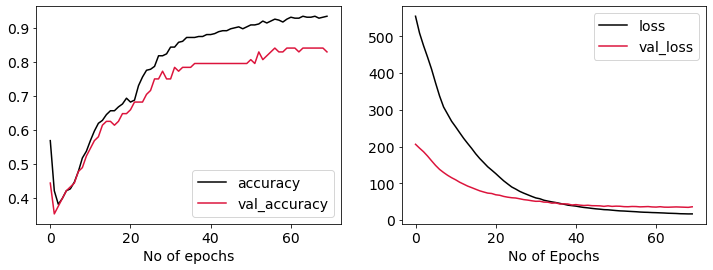

In [93]:
hist = history.history
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(hist['accuracy'] , label = 'accuracy' , color='k')
plt.plot(hist['val_accuracy'] , label = 'val_accuracy' , color='crimson')
plt.xlabel('No of epochs')
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist['loss'] , label = 'loss' , color='k')
plt.plot(hist['val_loss'] , label='val_loss' , color='crimson')
plt.xlabel("No of Epochs")
plt.legend()
#plt.savefig('plots/NS_BH.png')
plt.show()

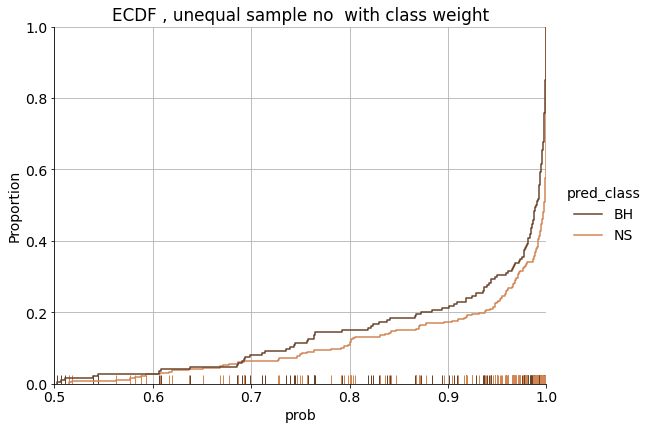

In [94]:
test_data_result = train_data.copy(deep=True)
y_prob = model.predict(x_train)

y_pred = []
for yi in y_prob:
    temp = [int(0)]*len(yi)
    temp[np.argmax(yi)] = int(1)
    y_pred.append(temp)
y_pred =  np.asarray(y_pred)

y_prob_val = [np.amax(yi) for yi in y_prob]
y_prob_class =[classes[np.argmax(yi)] for yi in y_prob]
y_truth = [np.dot(yi , yt) for yi , yt in zip(y_pred , one_hot_y_train)]
y_truth = np.asarray(y_truth)
test_data_result.insert(3 ,'pred_class' , y_prob_class)
test_data_result.insert(4 ,'prob' , y_prob_val)
test_data_result.insert(2 ,'is_ok' , y_truth.astype(int))

test_data_result = test_data_result.sort_values(by='src_id' , axis=0)
#test_data_result = test_data_result.drop(columns=['index'])
test_data_result.to_csv('temp.csv')

#plt.figure( figisze=(8,6))
data = pd.read_csv('temp.csv')
#data = test_data_result.copy()
data = data[['prob' ,'pred_class']]
s = sns.displot(
    data = data, x='prob' , 
    hue='pred_class' , kind='ecdf' , 
    rug=True, height=6 , aspect=8/6 , palette='copper')
#s.set_titles("Predicted prob distribution")
plt.xlim(0.5 , 1.0)
plt.title("ECDF , unequal sample no  with class weight")
#plt.axvline(1.0 , 0,5 , color='black')
plt.grid()
plt.savefig('pred_result/ns_bh_post_prob_ecdf_improved_net_unequal_sample.jpg')
plt.show()
plt.close()